# 1.6 Error estimation & adaptive refinement


In this tutorial, we apply a Zienkiewicz-Zhu type error estimator and run an adaptive loop with these steps:
$$
\text{SOLVE}\rightarrow
\text{ESIMATE}\rightarrow
\text{MARK}\rightarrow
\text{REFINE}\rightarrow
\text{SOLVE} \rightarrow \ldots
$$

In [1]:
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.occ import *
import matplotlib.pyplot as plt

### Geometry

The following geometry represents a heated chip embedded in another material that conducts away the heat.

In [2]:
def MakeGeometryOCC():
    base = Rectangle(1, 0.6).Face()
    chip = MoveTo(0.5,0.15).Line(0.15,0.15).Line(-0.15,0.15).Line(-0.15,-0.15).Close().Face()
    top = MoveTo(0.2,0.6).Rectangle(0.6,0.2).Face()
    base -= chip

    base.faces.name="base"
    chip.faces.name="chip"
    chip.faces.col=(1,0,0)
    top.faces.name="top"
    geo = Glue([base,chip,top])
    geo.edges.name="default"
    geo.edges.Min(Y).name="bot"
    return OCCGeometry(geo, dim=2)

mesh = Mesh(MakeGeometryOCC().GenerateMesh(maxh=0.2))
Draw(mesh)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

### Spaces & forms

The problem is to find $u$ in $H_{0,D}^1$ satisfying 

$$
\int_\Omega \lambda \nabla u \cdot \nabla v = \int_\Omega f v 
$$

for all $v$ in $H_{0,D}^1$. We expect the solution to have singularities due to the nonconvex re-enrant angles and discontinuities in $\lambda$.

In [3]:
fes = H1(mesh, order=3, dirichlet=[1])
u, v = fes.TnT()

# one heat conductivity coefficient per sub-domain
lam = CoefficientFunction([1, 1000, 10])
a = BilinearForm(lam*grad(u)*grad(v)*dx)

# heat-source in inner subdomain
f = LinearForm(fes)
f = LinearForm(1*v*dx(definedon="chip"))

c = Preconditioner(a, type="multigrid", inverse="sparsecholesky")

gfu = GridFunction(fes)

Note that the linear system is not yet assembled above.

### Solve 

Since we must solve multiple times, we define a function to solve the boundary value problem, where assembly, update, and solve occurs.

In [4]:
def SolveBVP():
    fes.Update()
    gfu.Update()
    a.Assemble()
    f.Assemble()
    inv = CGSolver(a.mat, c.mat)
    gfu.vec.data = inv * f.vec

In [5]:
SolveBVP()
Draw(gfu);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

### Estimate

We implement a gradient-recovery-type error estimator. For this, we need an H(div) space for flux recovery. We must compute the flux  of the computed solution and interpolate it into this H(div) space.

In [6]:
space_flux = HDiv(mesh, order=2)
gf_flux = GridFunction(space_flux, "flux")

flux = lam * grad(gfu)
gf_flux.Set(flux)

**Element-wise error estimator:** On each element $T$, set 

$$
\eta_T^2 = \int_T \frac{1}{\lambda} 
|\lambda \nabla u_h - I_h(\lambda \nabla u_h) |^2
$$

where $u_h$ is the computed solution `gfu` and $I_h$ is the interpolation performed by `Set` in NGSolve.


In [7]:
err = 1/lam*(flux-gf_flux)*(flux-gf_flux)
Draw(err, mesh, 'error_representation')

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

In [8]:
eta2 = Integrate(err, mesh, VOL, element_wise=True)
print(eta2)

 6.68417e-10
 7.62254e-08
 8.65452e-06
 5.00116e-10
 8.8811e-08
 5.49489e-09
 3.02529e-07
 7.32725e-10
 1.12641e-08
 2.98627e-08
 1.04189e-07
 2.50948e-07
 7.0518e-08
 8.00722e-07
 7.60703e-06
 9.7881e-07
 7.00995e-08
 7.58091e-06
 2.03482e-06
 2.44616e-08
 1.60629e-07
 6.52305e-08
 1.65889e-06
 1.15213e-06
 3.48558e-07
 2.50622e-06
 1.38426e-09
 1.80477e-06
 1.12638e-06
 4.9493e-08
 1.55159e-07
 1.58315e-09
 1.90147e-08
 1.92754e-08
 1.1525e-09
 9.74872e-10
 6.82708e-09
 8.52244e-10
 1.43383e-10
 9.7114e-09



The above values, one per element, lead us to identify elements which might have large error.


### Mark 

We mark elements with large error estimator for refinement.

In [9]:
maxerr = max(eta2)
print ("maxerr = ", maxerr)

for el in mesh.Elements():
    mesh.SetRefinementFlag(el, eta2[el.nr] > 0.25*maxerr)
    # see below for vectorized alternative

maxerr =  8.654516606473004e-06


### Refine & solve again 

Refine marked elements:

In [10]:
mesh.Refine()
SolveBVP()
Draw(gfu)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

### Automate the above steps

In [11]:
l = []    # l = list of estimated total error

def CalcError():

    # compute the flux:
    space_flux.Update()      
    gf_flux.Update()
    flux = lam * grad(gfu)        
    gf_flux.Set(flux) 
    
    # compute estimator:
    err = 1/lam*(flux-gf_flux)*(flux-gf_flux)
    eta2 = Integrate(err, mesh, VOL, element_wise=True)
    maxerr = max(eta2)
    l.append ((fes.ndof, sqrt(sum(eta2))))
    print("ndof =", fes.ndof, " maxerr =", maxerr)
    
    # mark for refinement (vectorized alternative)
    mesh.ngmesh.Elements2D().NumPy()["refine"] = eta2.NumPy() > 0.25*maxerr

In [12]:
CalcError()
mesh.Refine()

ndof = 355  maxerr = 5.091895627858492e-06


### Run the adaptive loop

In [13]:
level = 0 
while fes.ndof < 50000:  
    SolveBVP()
    level = level + 1
    if level%5 == 0:
        print('adaptive step #', level)
        Draw(gfu)
    CalcError()
    mesh.Refine()

ndof = 610  maxerr = 2.045384856532007e-06
ndof = 1057  maxerr = 8.120392556997195e-07
ndof = 1498  maxerr = 3.221537925921143e-07
ndof = 2176  maxerr = 1.2779488709486954e-07
adaptive step # 5


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

ndof = 2977  maxerr = 5.067814623451709e-08
ndof = 3895  maxerr = 2.0093310174636197e-08
ndof = 4711  maxerr = 8.091450961742305e-09
ndof = 5509  maxerr = 3.867954263623094e-09
ndof = 6271  maxerr = 1.8531027594470587e-09
adaptive step # 10


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

ndof = 6934  maxerr = 8.888730351282456e-10
ndof = 7678  maxerr = 4.266427654417152e-10
ndof = 8611  maxerr = 2.048473943087721e-10
ndof = 9745  maxerr = 9.83717026190594e-11
ndof = 10642  maxerr = 4.724468645497604e-11
adaptive step # 15


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

ndof = 12292  maxerr = 2.2691238346565618e-11
ndof = 13735  maxerr = 1.089848473608873e-11
ndof = 15721  maxerr = 5.234627253851985e-12
ndof = 17944  maxerr = 2.5142372957511452e-12
ndof = 20470  maxerr = 1.2076188731980018e-12
adaptive step # 20


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

ndof = 23848  maxerr = 5.800220063025054e-13
ndof = 27451  maxerr = 2.7859734149958696e-13
ndof = 32353  maxerr = 1.3380949493461505e-13
ndof = 38077  maxerr = 6.42723922885777e-14
ndof = 43858  maxerr = 3.086943972924289e-14
adaptive step # 25


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

ndof = 51115  maxerr = 1.48274888184822e-14


### Plot history of adaptive convergence

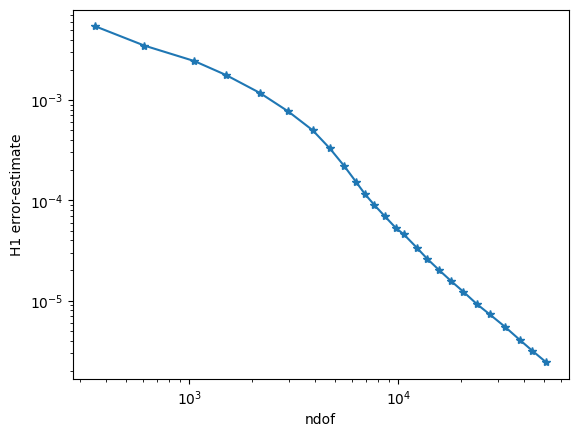

In [14]:
plt.yscale('log')
plt.xscale('log')
plt.xlabel("ndof")
plt.ylabel("H1 error-estimate")
ndof,err = zip(*l)
plt.plot(ndof,err, "-*")

plt.ion()
plt.show()